## INFOSYS 722 Assignement Iteration 4

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
spark = SparkSession.builder.appName('infosys722-i4').getOrCreate()

### Read Raw Data

In [3]:
raw_data_products = spark.read.options(compression='gzip').csv('./Datasets/2017PurchasePricesDec.csv.gz', inferSchema=True, header=True)
raw_data_inventory = spark.read.options(compression='gzip').csv('./Datasets/BegInvFINAL12312016.csv.gz', inferSchema=True, header=True)
raw_data_inventory_end = spark.read.options(compression='gzip').csv('./Datasets/EndInvFINAL12312016.csv.gz', inferSchema=True, header=True)
raw_data_purchase_order = spark.read.options(compression='gzip').csv('./Datasets/InvoicePurchases12312016.csv.gz', inferSchema=True, header=True)
raw_data_purchase_detail = spark.read.options(compression='gzip').csv('./Datasets/PurchasesFINAL12312016.csv.gz', inferSchema=True, header=True)
raw_data_sales = spark.read.options(compression='gzip').csv('./Datasets/SalesFINAL12312016.csv.gz', inferSchema=True, header=True)

### Data Understanding, Data Cleaning and Data Preparation

#### Describe Data

In [4]:
raw_data_products.head()

Row(Brand=58, Description='Gekkeikan Black & Gold Sake', Price=12.99, Size='750mL', Volume='750', Classification=1, PurchasePrice=9.28, VendorNumber=8320, VendorName='SHAW ROSS INT L IMP LTD    ')

In [5]:
raw_data_inventory.head()

Row(InventoryId='1_HARDERSFIELD_58', Store=1, City='HARDERSFIELD', Brand=58, Description='Gekkeikan Black & Gold Sake', Size='750mL', onHand=8, Price=12.99, startDate=datetime.date(2016, 1, 1))

In [6]:
raw_data_inventory_end.head()

Row(InventoryId='1_HARDERSFIELD_58', Store=1, City='HARDERSFIELD', Brand=58, Description='Gekkeikan Black & Gold Sake', Size='750mL', onHand=11, Price=12.99, endDate=datetime.date(2016, 12, 31))

In [7]:
raw_data_purchase_order.head()

Row(VendorNumber=105, VendorName='ALTAMAR BRANDS LLC         ', InvoiceDate=datetime.date(2016, 1, 4), PONumber=8124, PODate=datetime.date(2015, 12, 21), PayDate=datetime.date(2016, 2, 16), Quantity=6, Dollars=214.26, Freight=3.47, Approval='None')

In [8]:
raw_data_purchase_detail.head()

Row(InventoryId='69_MOUNTMEND_8412', Store=69, Brand=8412, Description='Tequila Ocho Plata Fresno', Size='750mL', VendorNumber=105, VendorName='ALTAMAR BRANDS LLC         ', PONumber=8124, PODate=datetime.date(2015, 12, 21), ReceivingDate=datetime.date(2016, 1, 2), InvoiceDate=datetime.date(2016, 1, 4), PayDate=datetime.date(2016, 2, 16), PurchasePrice=35.71, Quantity=6, Dollars=214.26, Classification=1)

In [9]:
raw_data_sales.head()

Row(InventoryId='1_HARDERSFIELD_1004', Store=1, Brand=1004, Description='Jim Beam w/2 Rocks Glasses', Size='750mL', SalesQuantity=1, SalesDollars=16.49, SalesPrice=16.49, SalesDate='1/1/2016', Volume=750, Classification=1, ExciseTax=0.79, VendorNo=12546, VendorName='JIM BEAM BRANDS COMPANY    ')

In [10]:
def print_summary(dataframe):
    summary = dataframe.summary()
    columns = ['feature'] + [row['summary'] for row in summary.collect()]
    data = []
    for feature in summary.columns[1:]:
        data.append([feature, *[row[feature] for row in summary.collect()]])
    spark.createDataFrame(data, schema=columns).show()

In [11]:
raw_data_products.printSchema()
print_summary(raw_data_products)

root
 |-- Brand: integer (nullable = true)
 |-- Description: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Size: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Classification: integer (nullable = true)
 |-- PurchasePrice: double (nullable = true)
 |-- VendorNumber: integer (nullable = true)
 |-- VendorName: string (nullable = true)

+--------------+-----+------------------+------------------+--------------------+-----+-----+-----+--------------------+
|       feature|count|              mean|            stddev|                 min|  25%|  50%|  75%|                 max|
+--------------+-----+------------------+------------------+--------------------+-----+-----+-----+--------------------+
|         Brand|12261|17989.067123399396|12528.503463986654|                  58| 5989|18787|25113|               90631|
|   Description|12260|              null|              null|              (RI) 1| null| null| null|   von Buhl Jazz Rsl|
|         Price|12

In [12]:
raw_data_inventory.printSchema()
print_summary(raw_data_inventory)

root
 |-- InventoryId: string (nullable = true)
 |-- Store: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- Brand: integer (nullable = true)
 |-- Description: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- onHand: integer (nullable = true)
 |-- Price: double (nullable = true)
 |-- startDate: date (nullable = true)

+-----------+------+------------------+------------------+--------------------+----+-----+-----+-----------------+
|    feature| count|              mean|            stddev|                 min| 25%|  50%|  75%|              max|
+-----------+------+------------------+------------------+--------------------+----+-----+-----+-----------------+
|InventoryId|206529|              null|              null|     10_HORNSEY_1000|null| null| null|  9_BLACKPOOL_999|
|      Store|206529| 42.12245737886689|23.191393409648104|                   1|  22|   42|   64|               79|
|       City|206529|              null|              null|            

In [13]:
raw_data_inventory_end.printSchema()
print_summary(raw_data_inventory_end)

root
 |-- InventoryId: string (nullable = true)
 |-- Store: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- Brand: integer (nullable = true)
 |-- Description: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- onHand: integer (nullable = true)
 |-- Price: double (nullable = true)
 |-- endDate: date (nullable = true)

+-----------+------+------------------+------------------+--------------------+----+-----+-----+-----------------+
|    feature| count|              mean|            stddev|                 min| 25%|  50%|  75%|              max|
+-----------+------+------------------+------------------+--------------------+----+-----+-----+-----------------+
|InventoryId|224489|              null|              null|     10_HORNSEY_1001|null| null| null|  9_BLACKPOOL_984|
|      Store|224489|43.505739702168036|23.326415082417782|                   1|  23|   44|   66|               81|
|       City|223205|              null|              null|            AB

In [14]:
raw_data_purchase_order.printSchema()
print_summary(raw_data_purchase_order)

root
 |-- VendorNumber: integer (nullable = true)
 |-- VendorName: string (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- PONumber: integer (nullable = true)
 |-- PODate: date (nullable = true)
 |-- PayDate: date (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Dollars: double (nullable = true)
 |-- Freight: double (nullable = true)
 |-- Approval: string (nullable = true)

+------------+-----+------------------+------------------+--------------------+------+-------+--------+--------------------+
|     feature|count|              mean|            stddev|                 min|   25%|    50%|     75%|                 max|
+------------+-----+------------------+------------------+--------------------+------+-------+--------+--------------------+
|VendorNumber| 5543|20662.752119790726| 34582.15840981278|                   2|  3089|   7240|   10754|              201359|
|  VendorName| 5543|              null|              null|AAPER ALCOHOL & C...|  null|   null

In [15]:
raw_data_purchase_detail.printSchema()
print_summary(raw_data_purchase_detail)

root
 |-- InventoryId: string (nullable = true)
 |-- Store: integer (nullable = true)
 |-- Brand: integer (nullable = true)
 |-- Description: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- VendorNumber: integer (nullable = true)
 |-- VendorName: string (nullable = true)
 |-- PONumber: integer (nullable = true)
 |-- PODate: date (nullable = true)
 |-- ReceivingDate: date (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- PayDate: date (nullable = true)
 |-- PurchasePrice: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Dollars: double (nullable = true)
 |-- Classification: integer (nullable = true)

+--------------+-------+------------------+------------------+--------------------+-----+-----+------+--------------------+
|       feature|  count|              mean|            stddev|                 min|  25%|  50%|   75%|                 max|
+--------------+-------+------------------+------------------+--------------------+-----+--

In [16]:
raw_data_sales.printSchema()
print_summary(raw_data_sales)

root
 |-- InventoryId: string (nullable = true)
 |-- Store: integer (nullable = true)
 |-- Brand: integer (nullable = true)
 |-- Description: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- SalesQuantity: integer (nullable = true)
 |-- SalesDollars: double (nullable = true)
 |-- SalesPrice: double (nullable = true)
 |-- SalesDate: string (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Classification: integer (nullable = true)
 |-- ExciseTax: double (nullable = true)
 |-- VendorNo: integer (nullable = true)
 |-- VendorName: string (nullable = true)

+--------------+-------+------------------+-------------------+--------------------+-----+-----+-----+--------------------+
|       feature|  count|              mean|             stddev|                 min|  25%|  50%|  75%|                 max|
+--------------+-------+------------------+-------------------+--------------------+-----+-----+-----+--------------------+
|   InventoryId|1048575|              nul

#### Data Cleaning - Replace invalid data, Correct measurement error, Correct date format, Align features' names

In [17]:
def replace(dataframe, column, condition, new_value):
    return dataframe.withColumn(column, F.when(condition, new_value).otherwise(dataframe[column]))

#
# replace invalid value
#
raw_data_products = replace(raw_data_products, 'Volume', raw_data_products['Volume'].isNull(), 0)
raw_data_products = replace(raw_data_products, 'Volume', raw_data_products['Volume'] == 'Unknown', 0)
raw_data_products = replace(raw_data_products, 'Volume', raw_data_products['Volume'] == '162.5', 162)

#
# Correct Data Type
#
dtype_products = {
    'Brand': 'string',
    'Description': 'string',
    'Price': 'float',
    'Size': 'string',
    'Volume': 'int',
    'Classification': 'string',
    'PurchasePrice': 'float',
    'VendorNumber': 'string',
    'VendorName': 'string',
}
    
dtype_inventory_begin = {    
    'InventoryId': 'string',
    'Store': 'string',
    'City': 'string',
    'Brand': 'string',
    'Description': 'string',
    'Size': 'string',
    'onHand': 'int',
    'Price': 'float',
    'startDate': 'string',
}    

dtype_inventory_end = { 
    'InventoryId': 'string',
    'Store': 'string',
    'City': 'string',
    'Brand': 'string',
    'Description': 'string',
    'Size': 'string',
    'onHand': 'int',
    'Price': 'float',
    'endDate': 'string',
}    

dtype_purchase_order = {    
    'VendorNumber': 'string',
    'VendorName': 'string',
    'InvoiceDate': 'string',
    'PONumber': 'string',
    'PODate': 'string',
    'PayDate': 'string',
    'Quantity': 'int',
    'Dollars': 'float',
    'Freight': 'float',
    'Approval': 'string',
}

dtype_purchase_detail = {
    'InventoryId': 'string',
    'Store': 'string',
    'Brand': 'string',
    'Description': 'string',
    'Size': 'string',
    'VendorNumber': 'string',
    'VendorName': 'string',
    'PONumber': 'string',
    'PODate': 'string',
    'ReceivingDate': 'string',
    'InvoiceDate': 'string',
    'PayDate': 'string',
    'PurchasePrice': 'float',
    'Quantity': 'int',
    'Dollars': 'float',
    'Classification': 'string',
}   
    
dtype_sales = {    
    'InventoryId': 'string',
    'Store': 'string',
    'Brand': 'string',
    'Description': 'string',
    'Size': 'string',
    'SalesQuantity': 'int',
    'SalesDollars': 'float',
    'SalesPrice': 'float',
    'SalesDate': 'string',
    'Volume': 'int',
    'Classification': 'string',
    'ExciseTax': 'float',
    'VendorNo': 'string',
    'VendorName': 'string',
}

def correct_dtype(dataframe, dtype_dict):
    for column, dtype in dtype_dict.items():
        dataframe = dataframe.withColumn(column, F.col(column).cast(dtype))
    return dataframe

raw_data_products = correct_dtype(raw_data_products, dtype_products)
raw_data_inventory = correct_dtype(raw_data_inventory, dtype_inventory_begin)
raw_data_inventory_end = correct_dtype(raw_data_inventory_end, dtype_inventory_end)
raw_data_purchase_order = correct_dtype(raw_data_purchase_order, dtype_purchase_order)
raw_data_purchase_detail = correct_dtype(raw_data_purchase_detail, dtype_purchase_detail)
raw_data_sales = correct_dtype(raw_data_sales, dtype_sales)

#
# Convert date string to datetime
#

def format_date(dataframe, columns, date_format='yyyy-MM-dd'):
    for column in columns:
        dataframe = dataframe.withColumn(column, F.to_date(column, date_format))
    return dataframe
        
raw_data_inventory = format_date(raw_data_inventory, ['startDate'])
raw_data_inventory_end = format_date(raw_data_inventory_end, ['endDate'])
raw_data_purchase_order = format_date(raw_data_purchase_order, ['PODate', 'InvoiceDate', 'PayDate'])
raw_data_purchase_detail = format_date(raw_data_purchase_detail, ['PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate'])
raw_data_sales = format_date(raw_data_sales, ['SalesDate'], date_format = 'M/d/yyyy')

#
# Align features' name across datasets
#
# VendorNo in Sales should be renamed to VendorNumber
raw_data_sales = raw_data_sales.withColumnRenamed('VendorNo', 'VendorNumber')

In [18]:
raw_data_products.printSchema()

root
 |-- Brand: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Price: float (nullable = true)
 |-- Size: string (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Classification: string (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- VendorName: string (nullable = true)



In [19]:
raw_data_inventory.printSchema()

root
 |-- InventoryId: string (nullable = true)
 |-- Store: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- onHand: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- startDate: date (nullable = true)



In [20]:
raw_data_inventory_end.printSchema()

root
 |-- InventoryId: string (nullable = true)
 |-- Store: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- onHand: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- endDate: date (nullable = true)



In [21]:
raw_data_purchase_order.printSchema()

root
 |-- VendorNumber: string (nullable = true)
 |-- VendorName: string (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- PONumber: string (nullable = true)
 |-- PODate: date (nullable = true)
 |-- PayDate: date (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Dollars: float (nullable = true)
 |-- Freight: float (nullable = true)
 |-- Approval: string (nullable = true)



In [22]:
raw_data_purchase_detail.printSchema()

root
 |-- InventoryId: string (nullable = true)
 |-- Store: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- VendorName: string (nullable = true)
 |-- PONumber: string (nullable = true)
 |-- PODate: date (nullable = true)
 |-- ReceivingDate: date (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- PayDate: date (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Dollars: float (nullable = true)
 |-- Classification: string (nullable = true)



In [23]:
raw_data_sales.printSchema()

root
 |-- InventoryId: string (nullable = true)
 |-- Store: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- SalesQuantity: integer (nullable = true)
 |-- SalesDollars: float (nullable = true)
 |-- SalesPrice: float (nullable = true)
 |-- SalesDate: date (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Classification: string (nullable = true)
 |-- ExciseTax: float (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- VendorName: string (nullable = true)



#### Select Related Data
The project only requires Store 15's data

In [24]:
selected_inventory = raw_data_inventory.where('Store = 15')
selected_purchase_detail = raw_data_purchase_detail.where('Store = 15')
selected_sales = raw_data_sales.where('Store = 15')

In [25]:
selected_inventory.select('Store').distinct().collect()

[Row(Store='15')]

In [26]:
selected_purchase_detail.select('Store').distinct().collect()

[Row(Store='15')]

In [27]:
selected_sales.select('Store').distinct().collect()

[Row(Store='15')]

##### Remove unused fields

In [28]:
selected_products = raw_data_products.drop('Description', 'VendorName')
selected_purchase_detail = selected_purchase_detail.drop('InventoryId', 'Store', 'Description', 'VendorName', 'PONumber')
selected_sales = selected_sales.drop('InventoryId', 'Store', 'Description', 'VendorName')

In [29]:
selected_products.printSchema()
selected_purchase_detail.printSchema()
selected_sales.printSchema()

root
 |-- Brand: string (nullable = true)
 |-- Price: float (nullable = true)
 |-- Size: string (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Classification: string (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- VendorNumber: string (nullable = true)

root
 |-- Brand: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- PODate: date (nullable = true)
 |-- ReceivingDate: date (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- PayDate: date (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Dollars: float (nullable = true)
 |-- Classification: string (nullable = true)

root
 |-- Brand: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- SalesQuantity: integer (nullable = true)
 |-- SalesDollars: float (nullable = true)
 |-- SalesPrice: float (nullable = true)
 |-- SalesDate: date (nullable = true)
 |-- Volume: int

#### Contruct New Features and Explore Data

In [30]:
# Construct DayOfWeek, DayOfMonth, Month fields
selected_sales = selected_sales.withColumn('DayOfWeek', F.dayofweek('SalesDate'))
selected_sales = selected_sales.withColumn('DayOfMonth', F.dayofmonth('SalesDate'))
selected_sales = selected_sales.withColumn('Month', F.month('SalesDate'))

selected_purchase_detail = selected_purchase_detail.withColumn('DeliverTime', F.datediff('ReceivingDate', 'PODate'))
selected_purchase_detail = selected_purchase_detail.withColumn('Month', F.month('ReceivingDate'))
selected_purchase_detail = selected_purchase_detail.withColumn('DayOfMonth', F.dayofmonth('ReceivingDate'))

In [31]:
selected_sales.head(3)

[Row(Brand='100', Size='750mL', SalesQuantity=1, SalesDollars=159.99000549316406, SalesPrice=159.99000549316406, SalesDate=datetime.date(2016, 1, 14), Volume=750, Classification='1', ExciseTax=0.7900000214576721, VendorNumber='17035', DayOfWeek=5, DayOfMonth=14, Month=1),
 Row(Brand='1001', Size='50mL 4 Pk', SalesQuantity=3, SalesDollars=17.969999313354492, SalesPrice=5.989999771118164, SalesDate=datetime.date(2016, 1, 2), Volume=50, Classification='1', ExciseTax=0.1599999964237213, VendorNumber='3960', DayOfWeek=7, DayOfMonth=2, Month=1),
 Row(Brand='1001', Size='50mL 4 Pk', SalesQuantity=2, SalesDollars=11.979999542236328, SalesPrice=5.989999771118164, SalesDate=datetime.date(2016, 1, 3), Volume=50, Classification='1', ExciseTax=0.10000000149011612, VendorNumber='3960', DayOfWeek=1, DayOfMonth=3, Month=1)]

In [32]:
selected_purchase_detail.head(3)

[Row(Brand='2663', Size='1.75L', VendorNumber='480', PODate=datetime.date(2015, 12, 20), ReceivingDate=datetime.date(2016, 1, 1), InvoiceDate=datetime.date(2016, 1, 12), PayDate=datetime.date(2016, 2, 5), PurchasePrice=21.420000076293945, Quantity=12, Dollars=257.0400085449219, Classification='1', DeliverTime=12, Month=1, DayOfMonth=1),
 Row(Brand='4050', Size='750mL', VendorNumber='480', PODate=datetime.date(2015, 12, 20), ReceivingDate=datetime.date(2016, 1, 1), InvoiceDate=datetime.date(2016, 1, 12), PayDate=datetime.date(2016, 2, 5), PurchasePrice=8.720000267028809, Quantity=12, Dollars=104.63999938964844, Classification='1', DeliverTime=12, Month=1, DayOfMonth=1),
 Row(Brand='4245', Size='750mL', VendorNumber='480', PODate=datetime.date(2015, 12, 20), ReceivingDate=datetime.date(2016, 1, 1), InvoiceDate=datetime.date(2016, 1, 12), PayDate=datetime.date(2016, 2, 5), PurchasePrice=7.929999828338623, Quantity=29, Dollars=229.97000122070312, Classification='1', DeliverTime=12, Month=1

##### Explore Sales Data

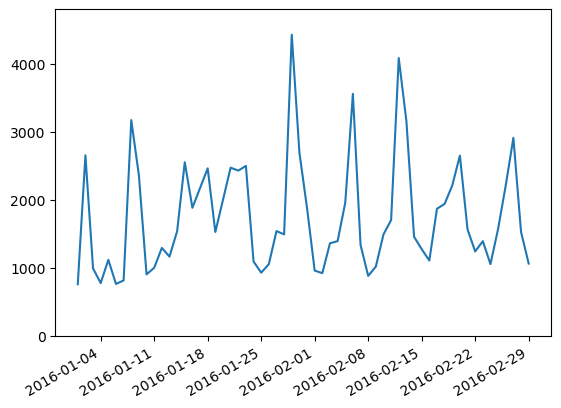

In [33]:
# Explore daily sales
daily_sales = selected_sales.groupBy('SalesDate').agg(F.sum('SalesQuantity').alias('DailySales')).orderBy('SalesDate')

dsp_df = daily_sales.toPandas()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.plot(dsp_df['SalesDate'], dsp_df['DailySales'])
plt.ylim([0,4800])
plt.gcf().autofmt_xdate()

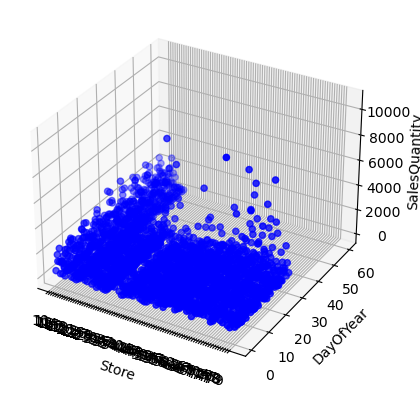

In [34]:
store_daily_sales = raw_data_sales.groupBy('Store', 'SalesDate').agg(F.sum('SalesQuantity').alias('SalesQuantity'))
store_daily_sales = store_daily_sales.withColumn('DayOfYear', F.dayofyear('SalesDate'))
dsp_df = store_daily_sales.orderBy('Store', 'DayOfYear').toPandas()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dsp_df['Store'], dsp_df['DayOfYear'], dsp_df['SalesQuantity'], c='b', marker='o')
ax.set_xlabel('Store')
ax.set_ylabel('DayOfYear')
ax.set_zlabel('SalesQuantity')
plt.show()

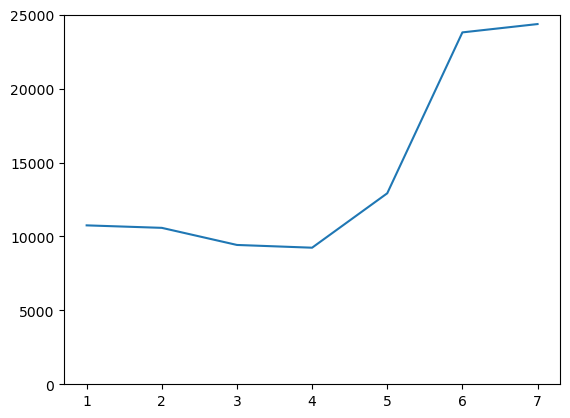

In [35]:
# Explore weekly sales
weekday_sales = selected_sales.groupby('DayOfWeek').agg(F.sum('SalesQuantity').alias('WeekdaySales')).orderBy('DayOfWeek')

dsp_df = weekday_sales.toPandas()
plt.plot(dsp_df['DayOfWeek'], dsp_df['WeekdaySales'])
plt.ylim([0, 25000])
plt.show()

##### Explore Purchase Details

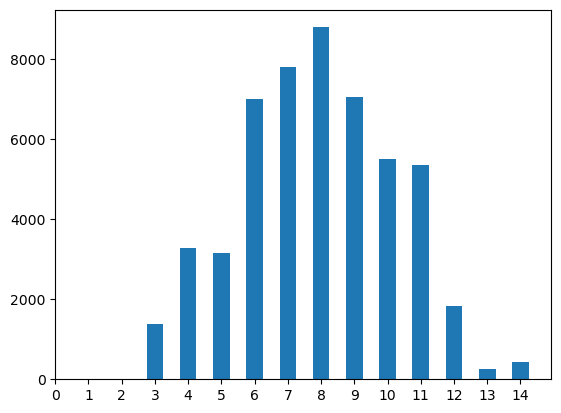

In [36]:
# Deliver Time Distribution
dsp_df = selected_purchase_detail.toPandas()
plt.hist(dsp_df['DeliverTime'], bins=[i+0.5 for i in range(0,15)], rwidth=0.5)
plt.xticks(range(0,15))
plt.show()

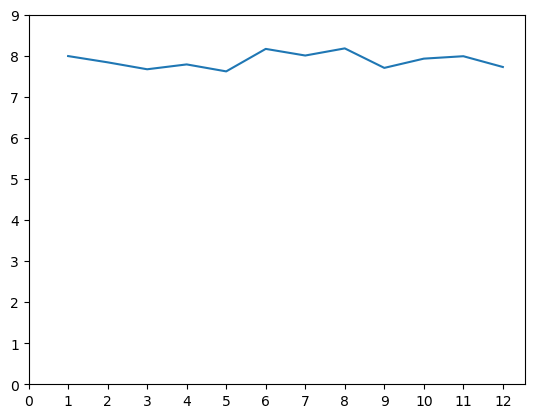

In [37]:
# Explore Montly Average Deliver Time
dsp_df = selected_purchase_detail.groupby('Month').agg(
        F.mean('DeliverTime').alias('MeanDeliveryTime')
    ).orderBy('Month').toPandas()
plt.plot(dsp_df['Month'], dsp_df['MeanDeliveryTime'])
plt.ylim([0,9])
plt.xticks(range(0,13))
plt.show()

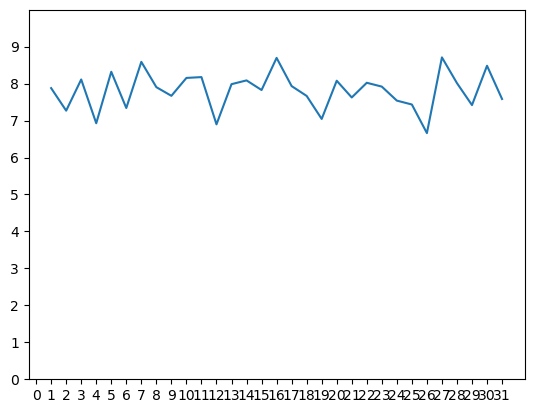

In [38]:
# Explore Daily Average Deliver Time across Months
dsp_df = selected_purchase_detail.groupby('DayOfMonth').agg(
        F.mean('DeliverTime').alias('MeanDeliveryTime')
    ).orderBy('DayOfMonth').toPandas()
plt.plot(dsp_df['DayOfMonth'], dsp_df['MeanDeliveryTime'])
plt.ylim([0,10])
plt.xticks(range(0,32))
plt.yticks(range(0,10))
plt.show()

##### Explore and Remove Extreme Values

In [39]:
# Check extremes in price field
selected_products.orderBy('Price', ascending=False).head(20)

[Row(Brand='2693', Price=13999.900390625, Size='750mL', Volume=750, Classification='1', PurchasePrice=11111.0302734375, VendorNumber='11567'),
 Row(Brand='3949', Price=7499.990234375, Size='750mL', Volume=750, Classification='1', PurchasePrice=5681.81005859375, VendorNumber='9165'),
 Row(Brand='2367', Price=5799.990234375, Size='1000mL', Volume=1000, Classification='1', PurchasePrice=4264.7001953125, VendorNumber='8112'),
 Row(Brand='1991', Price=4999.990234375, Size='750mL', Volume=750, Classification='1', PurchasePrice=3787.8701171875, VendorNumber='2561'),
 Row(Brand='4423', Price=4999.990234375, Size='750mL', Volume=750, Classification='1', PurchasePrice=3649.6298828125, VendorNumber='11567'),
 Row(Brand='423', Price=4559.990234375, Size='750mL', Volume=750, Classification='1', PurchasePrice=3352.929931640625, VendorNumber='8112'),
 Row(Brand='16191', Price=4222.990234375, Size='6000mL', Volume=6000, Classification='2', PurchasePrice=2816.429931640625, VendorNumber='9165'),
 Row(Br

In [40]:
# Check extremes in volume field
selected_products.orderBy('Volume', ascending=False).head(20)

[Row(Brand='23047', Price=230.49000549316406, Size='20000mL', Volume=20000, Classification='2', PurchasePrice=149.6699981689453, VendorNumber='90024'),
 Row(Brand='25463', Price=227.99000549316406, Size='20000mL', Volume=20000, Classification='2', PurchasePrice=155.10000610351562, VendorNumber='90047'),
 Row(Brand='23491', Price=346.989990234375, Size='20000mL', Volume=20000, Classification='2', PurchasePrice=204.60000610351562, VendorNumber='90047'),
 Row(Brand='25464', Price=251.49000549316406, Size='20000mL', Volume=20000, Classification='2', PurchasePrice=163.30999755859375, VendorNumber='90047'),
 Row(Brand='26146', Price=221.99000549316406, Size='20000mL', Volume=20000, Classification='2', PurchasePrice=151.00999450683594, VendorNumber='90011'),
 Row(Brand='22565', Price=183.99000549316406, Size='19500mL', Volume=19500, Classification='2', PurchasePrice=118.69999694824219, VendorNumber='4425'),
 Row(Brand='20650', Price=83.48999786376953, Size='18000mL', Volume=18000, Classificat

In [41]:
selected_sales.orderBy('SalesQuantity', ascending=False).head(20)

[Row(Brand='8576', Size='375mL', SalesQuantity=432, SalesDollars=2155.679931640625, SalesPrice=4.989999771118164, SalesDate=datetime.date(2016, 1, 8), Volume=375, Classification='1', ExciseTax=170.10000610351562, VendorNumber='3252', DayOfWeek=6, DayOfMonth=8, Month=1),
 Row(Brand='8441', Size='375mL', SalesQuantity=361, SalesDollars=4508.89013671875, SalesPrice=12.489999771118164, SalesDate=datetime.date(2016, 2, 12), Volume=375, Classification='1', ExciseTax=142.13999938964844, VendorNumber='3960', DayOfWeek=6, DayOfMonth=12, Month=2),
 Row(Brand='42188', Size='750mL', SalesQuantity=253, SalesDollars=13279.9697265625, SalesPrice=52.4900016784668, SalesDate=datetime.date(2016, 2, 6), Volume=750, Classification='2', ExciseTax=28.459999084472656, VendorNumber='8112', DayOfWeek=7, DayOfMonth=6, Month=2),
 Row(Brand='8512', Size='750mL', SalesQuantity=247, SalesDollars=4937.52978515625, SalesPrice=19.989999771118164, SalesDate=datetime.date(2016, 2, 6), Volume=750, Classification='1', Exc

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8eb96ad750>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8eb9684690>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8eb94c7ad0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8eb967c890>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8eb967e250>],
 'means': []}

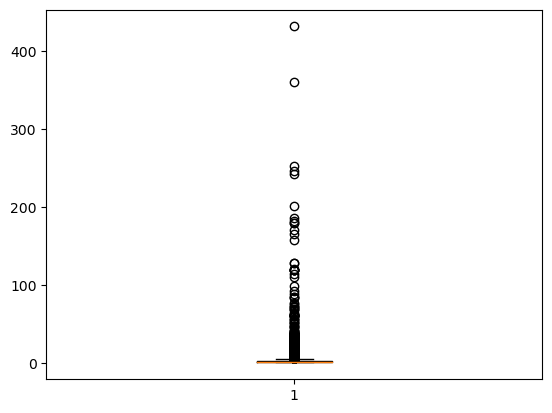

In [42]:
plt.boxplot(selected_sales.toPandas()['SalesQuantity'])

In [43]:
def remove_extreme_by_z_scores(dataframe, column, threshold = 1):
    mean, std = dataframe.agg(F.mean(column), F.stddev(column)).collect()[0]
    dataframe = dataframe.withColumn('z_scores', (F.col(column) - mean) / std)
    return dataframe.where(F.col('z_scores') <= threshold).drop('z_scores')

selected_sales = remove_extreme_by_z_scores(selected_sales, 'SalesQuantity')
selected_sales.describe('SalesQuantity').show()

+-------+------------------+
|summary|     SalesQuantity|
+-------+------------------+
|  count|             36962|
|   mean|1.9354201612466857|
| stddev|1.4654083220779113|
|    min|                 1|
|    max|                 8|
+-------+------------------+



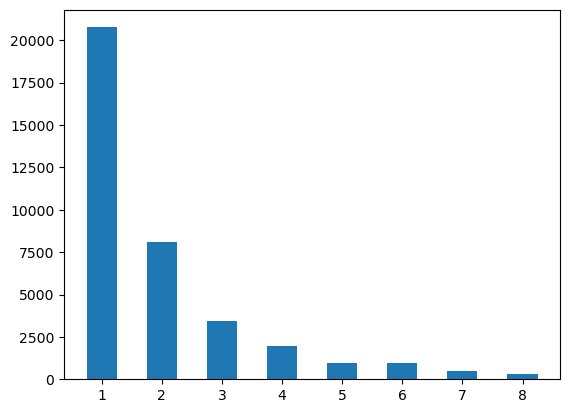

In [44]:
plt.hist(selected_sales.toPandas()['SalesQuantity'], bins=[i+0.5 for i in range(0, 9)], rwidth=0.5)
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8ebaf68450>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8eb94a5850>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8ebaf6a790>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8eb94a4910>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8eb94a5390>],
 'means': []}

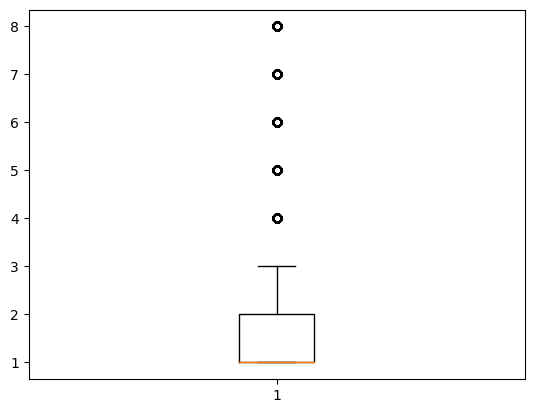

In [45]:
plt.boxplot(selected_sales.toPandas()['SalesQuantity'])

#### Integrate Purchase Detail with Products and Integrate Sales with Products

In [46]:
# Integrate product information to sales records and contruct ProfitRate fields
integrated_sales = selected_sales.join(selected_products.drop('Size', 'Volume', 'Classification', 'VendorNumber'), on='Brand', how='left')
integrated_sales = integrated_sales.withColumn('ProfitRate', (integrated_sales['SalesPrice'] - integrated_sales['PurchasePrice']) / integrated_sales['PurchasePrice'])
integrated_sales.printSchema()

root
 |-- Brand: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- SalesQuantity: integer (nullable = true)
 |-- SalesDollars: float (nullable = true)
 |-- SalesPrice: float (nullable = true)
 |-- SalesDate: date (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Classification: string (nullable = true)
 |-- ExciseTax: float (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- ProfitRate: double (nullable = true)



In [47]:
# Integrate product information to purchase details
integrated_purchase_detail = selected_purchase_detail.join(selected_products.drop('Size', 'VendorNumber', 'PurchasePrice', 'Classification'), on='Brand', how='left')
integrated_purchase_detail.printSchema()

root
 |-- Brand: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- PODate: date (nullable = true)
 |-- ReceivingDate: date (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- PayDate: date (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Dollars: float (nullable = true)
 |-- Classification: string (nullable = true)
 |-- DeliverTime: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- Volume: integer (nullable = true)



#### Reformat DayOfWeek and Month to string

In [48]:
day_of_week_mapping = {
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday",
    7: "Sunday"
}

month_mapping = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

def convert_data_type(dataframe, column, mapping, dtype=None):
    for key, value in mapping.items():
        dataframe = dataframe.withColumn(column, F.when(F.col(column) == key, value).otherwise(F.col(column)))
    if dtype is not None:
        dataframe = dataframe.withColumn(column, F.col(column).cast(dtype))
    return dataframe

integrated_purchase_detail = convert_data_type(integrated_purchase_detail, 'Month', month_mapping, 'string')
integrated_sales = convert_data_type(integrated_sales, 'DayOfWeek', day_of_week_mapping, 'string')
integrated_sales = convert_data_type(integrated_sales, 'Month', month_mapping, 'string')

In [49]:
integrated_purchase_detail.printSchema()

root
 |-- Brand: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- PODate: date (nullable = true)
 |-- ReceivingDate: date (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- PayDate: date (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Dollars: float (nullable = true)
 |-- Classification: string (nullable = true)
 |-- DeliverTime: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- Volume: integer (nullable = true)



In [50]:
integrated_sales.printSchema()

root
 |-- Brand: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- SalesQuantity: integer (nullable = true)
 |-- SalesDollars: float (nullable = true)
 |-- SalesPrice: float (nullable = true)
 |-- SalesDate: date (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Classification: string (nullable = true)
 |-- ExciseTax: float (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Price: float (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- ProfitRate: double (nullable = true)



### Remove unsuitable features

In [51]:
# Check unique brand
integrated_sales.select('Brand').distinct().count()

3746

In [52]:
# Check the relation between Classification, SalesQuantity and ExciseTax
tmp = integrated_sales.withColumn('TotalVolume', F.col('SalesQuantity') * F.col('Volume'))

print(tmp.where('Classification = 1').corr('TotalVolume', 'ExciseTax'))
print(tmp.where('Classification = 2').corr('TotalVolume', 'ExciseTax'))

0.9999989795442092
0.9999779956562865


In [53]:
integrated_sales = integrated_sales.drop('Brand', 'SalesDollars', 'SalesDate', 'Price', 'ExciseTax')
integrated_purchase_detail = integrated_purchase_detail.drop(
    'Brand', 'PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate', 'Quantity', 'Dollars')

In [54]:
integrated_sales.printSchema()

root
 |-- Size: string (nullable = true)
 |-- SalesQuantity: integer (nullable = true)
 |-- SalesPrice: float (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Classification: string (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- ProfitRate: double (nullable = true)



In [55]:
integrated_purchase_detail.printSchema()

root
 |-- Size: string (nullable = true)
 |-- VendorNumber: string (nullable = true)
 |-- PurchasePrice: float (nullable = true)
 |-- Classification: string (nullable = true)
 |-- DeliverTime: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- Volume: integer (nullable = true)



### Transform

#### Transformation for Purchase Detail

In [56]:
integrated_purchase_detail.where('PurchasePrice <= 0 or Price <= 0 or Volume <= 0').show()

+-----+------------+-------------+--------------+-----------+---------+----------+-----+------+
| Size|VendorNumber|PurchasePrice|Classification|DeliverTime|    Month|DayOfMonth|Price|Volume|
+-----+------------+-------------+--------------+-----------+---------+----------+-----+------+
|750mL|        2561|          0.0|             1|          9|   August|        11|  0.0|   750|
|750mL|        2561|          0.0|             1|          6|September|        29|  0.0|   750|
|750mL|        2561|          0.0|             1|          9| December|         8|  0.0|   750|
+-----+------------+-------------+--------------+-----------+---------+----------+-----+------+



In [57]:
# Remove invalid records in purchase detail
integrated_purchase_detail = integrated_purchase_detail.where('PurchasePrice > 0')

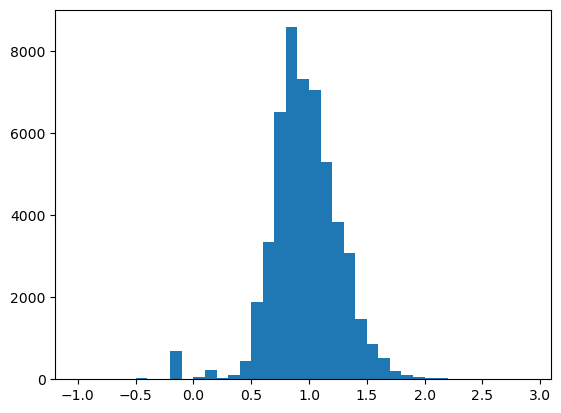

In [58]:
# Log10 transformation for Purchase Price
integrated_purchase_detail = integrated_purchase_detail.withColumn('PurchasePrice', F.log10(F.col('PurchasePrice')))
plt.hist(integrated_purchase_detail.toPandas()['PurchasePrice'], bins=[i/10 for i in range(-10,30)])
plt.show()

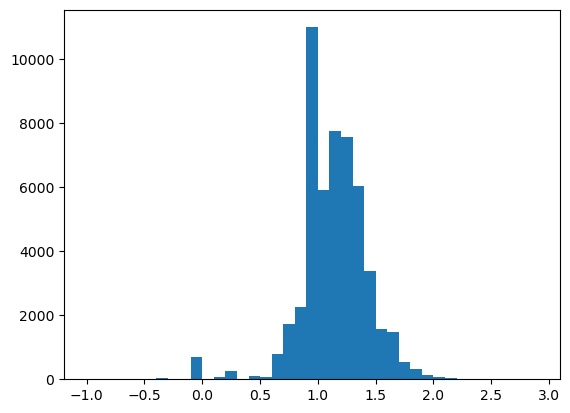

In [59]:
integrated_purchase_detail = integrated_purchase_detail.withColumn('Price', F.log10(F.col('Price')))
plt.hist(integrated_purchase_detail.toPandas()['Price'], bins=[i/10 for i in range(-10,30)])
plt.show()

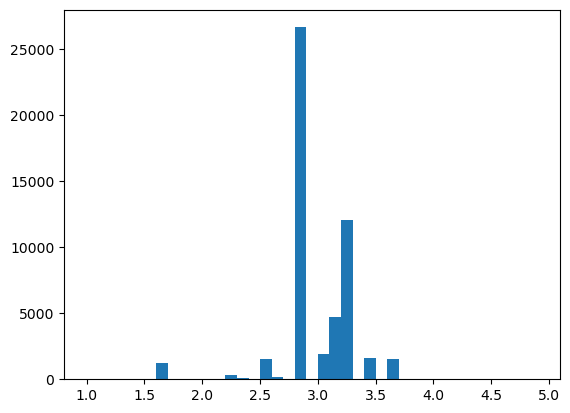

In [60]:
integrated_purchase_detail = integrated_purchase_detail.withColumn('Volume', F.log10(F.col('Volume')))
plt.hist(integrated_purchase_detail.toPandas()['Volume'], bins=[i/10 for i in range(10,50)])
plt.show()

#### Transformation for Sales

In [61]:
integrated_sales.where('PurchasePrice <=0 or SalesPrice <=0 or Volume <= 0').show()

+----+-------------+----------+------+--------------+------------+---------+----------+-----+-------------+----------+
|Size|SalesQuantity|SalesPrice|Volume|Classification|VendorNumber|DayOfWeek|DayOfMonth|Month|PurchasePrice|ProfitRate|
+----+-------------+----------+------+--------------+------------+---------+----------+-----+-------------+----------+
+----+-------------+----------+------+--------------+------------+---------+----------+-----+-------------+----------+



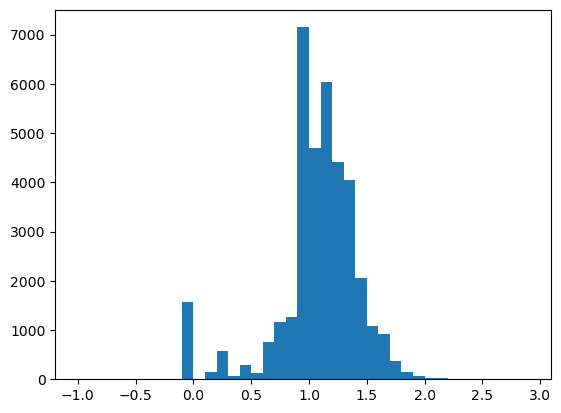

In [62]:
integrated_sales = integrated_sales.withColumn('SalesPrice', F.log10(F.col('SalesPrice')))
plt.hist(integrated_sales.toPandas()['SalesPrice'], bins=[i/10 for i in range(-10,30)])
plt.show()

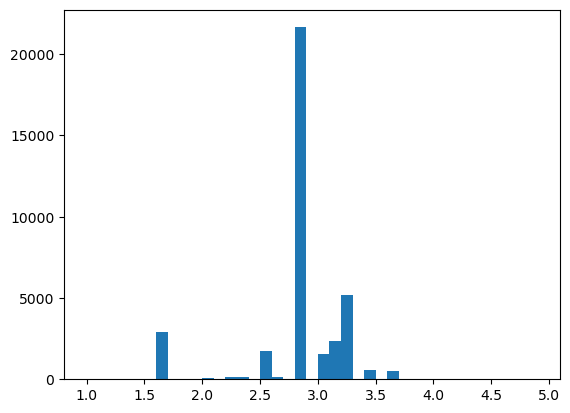

In [63]:
integrated_sales = integrated_sales.withColumn('Volume', F.log10(F.col('Volume')))
plt.hist(integrated_sales.toPandas()['Volume'], bins=[i/10 for i in range(10,50)])
plt.show()

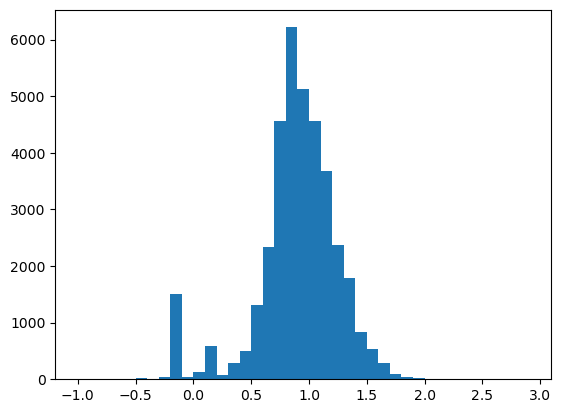

In [64]:
integrated_sales = integrated_sales.withColumn('PurchasePrice', F.log10(F.col('PurchasePrice')))
plt.hist(integrated_sales.toPandas()['PurchasePrice'], bins=[i/10 for i in range(-10,30)])
plt.show()

## Modeling

In [65]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

import tensorflow as tf
from tensorflow import keras

In [79]:
def evaluate_regression_model(result, labelCol, predictionCol='prediction', metrics = ['rmse', 'mse', 'mae', 'r2']):
    results = [(metric, RegressionEvaluator(labelCol=labelCol, metricName=metric, predictionCol=predictionCol).evaluate(result)) for metric in metrics]
    for metric, result in results:
        print(f'{metric}: {result}')
    return dict(results)
    
def get_string_indexers(dataframe, suffix='_index'):
    indexers = []
    for feature, dtype in dataframe.dtypes:
        if dtype == 'string':
            indexers.append(StringIndexer(inputCol=feature, outputCol=feature + suffix))
    return indexers

def generate_baseline(dataframe, target):
    target_mean = dataframe.agg(F.mean(target)).collect()[0][0]
    return dataframe.withColumn('baseline_prediction', F.lit(target_mean))

### Predicting Deliver Time

In [67]:
train, test = integrated_purchase_detail.randomSplit([0.7, 0.3], seed=13)

In [68]:
# Baseline
evaluate_regression_model(generate_baseline(test, 'DeliverTime'), 'DeliverTime', predictionCol='baseline_prediction')

rmse: 2.3293633036031793
mse: 5.425933400173117
mae: 1.8845835325306026
r2: 2.398081733190338e-14


rmse: 2.3288568471802984
mse: 5.42357421465856
mae: 1.8868793667534833
r2: 0.00043479809660240676


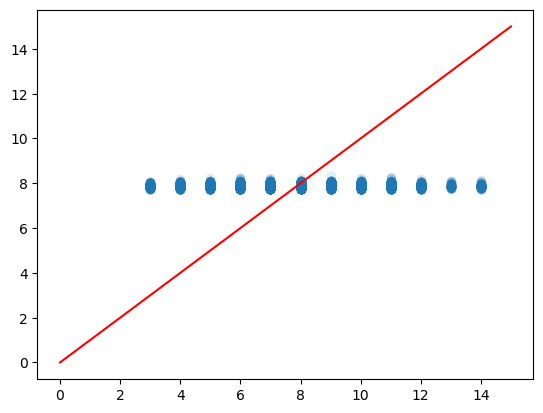

In [69]:
# Linear Regression
model_pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=['PurchasePrice', 'DayOfMonth', 'Price', 'Volume'], outputCol='numeric_features'),
    LinearRegression(labelCol='DeliverTime', featuresCol='numeric_features'),
])

model = model_pipeline.fit(train)
result = model.transform(test)

evaluate_regression_model(result, 'DeliverTime')

dsp_df = result.toPandas()
plt.scatter(dsp_df['DeliverTime'], dsp_df['prediction'], alpha=0.1)
plt.plot(range(0,16), c='r')
plt.show()

rmse: 1.6910494101845122
mse: 2.859648107685387
mae: 1.2378760823562895
r2: 0.4729666037563086


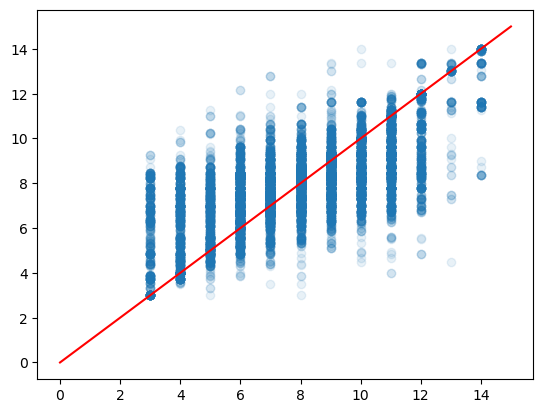

In [70]:
# Decision Tree
transformation_pipeline = Pipeline(stages=get_string_indexers(integrated_purchase_detail) + [
    VectorAssembler(inputCols=[
        'PurchasePrice', 'DayOfMonth', 'Price', 'Volume', 
        'Size_index', 'Classification_index', 'Month_index', 'VendorNumber_index'], 
                    outputCol='features')
])

dtr = DecisionTreeRegressor(maxDepth=10, labelCol='DeliverTime', featuresCol='features', maxBins=256)

transformer = transformation_pipeline.fit(integrated_purchase_detail)
model = dtr.fit(transformer.transform(train))
result = model.transform(transformer.transform(test))

evaluate_regression_model(result, 'DeliverTime')

dsp_df = result.toPandas()
plt.scatter(dsp_df['DeliverTime'], dsp_df['prediction'], alpha=0.1)
plt.plot(range(0,16), c='r')
plt.show()

rmse: 1.8801403779592443
mse: 3.5349278408327303
mae: 1.5249828477987415
r2: 0.34851248990268435


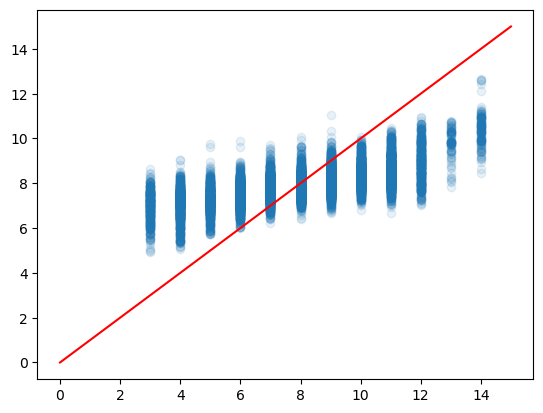

In [71]:
# Random Forest
transformation_pipeline = Pipeline(stages=get_string_indexers(integrated_purchase_detail) + [
    VectorAssembler(inputCols=[
        'PurchasePrice', 'DayOfMonth', 'Price', 'Volume', 
        'Size_index', 'Classification_index', 'Month_index', 'VendorNumber_index'], 
                    outputCol='features')
])

rfr = RandomForestRegressor(maxDepth=10, labelCol='DeliverTime', featuresCol='features', maxBins=256)

transformer = transformation_pipeline.fit(integrated_purchase_detail)
model = rfr.fit(transformer.transform(train))
result = model.transform(transformer.transform(test))

evaluate_regression_model(result, 'DeliverTime')

dsp_df = result.toPandas()
plt.scatter(dsp_df['DeliverTime'], dsp_df['prediction'], alpha=0.1)
plt.plot(range(0,16), c='r')
plt.show()

### Predicting Sales

In [72]:
train, test = integrated_sales.randomSplit([0.7, 0.3], seed=13)

In [73]:
# Baseline
evaluate_regression_model(generate_baseline(test, 'SalesQuantity'), 'SalesQuantity', predictionCol='baseline_prediction')

rmse: 1.461097491828544
mse: 2.134805880627662
mae: 1.0440393748091814
r2: -9.747758156208874e-14


rmse: 1.4285495864641824
mse: 2.0407539209869863
mae: 1.0257602120631375
r2: 0.04405644583142343


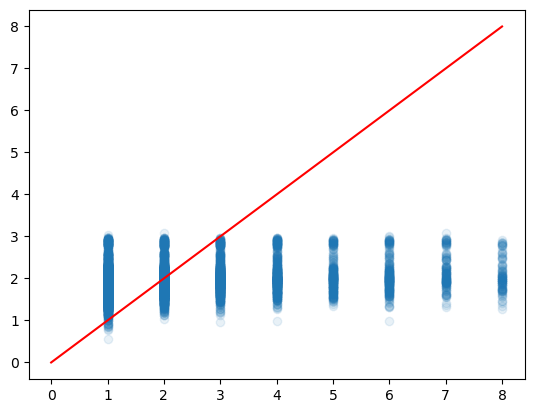

In [74]:
# Linear Regression
model_pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=['SalesPrice', 'Volume', 'DayOfMonth', 'PurchasePrice', 'ProfitRate'], outputCol='numeric_features'),
    LinearRegression(labelCol='SalesQuantity', featuresCol='numeric_features'),
])

model = model_pipeline.fit(train)
result = model.transform(test)

evaluate_regression_model(result, 'SalesQuantity')

dsp_df = result.toPandas()
plt.scatter(dsp_df['SalesQuantity'], dsp_df['prediction'], alpha=0.1)
plt.plot(range(0,9), c='r')
plt.show()

rmse: 1.4158659781384333
mse: 2.0046764680499023
mae: 0.9952645068538889
r2: 0.06095608680790432


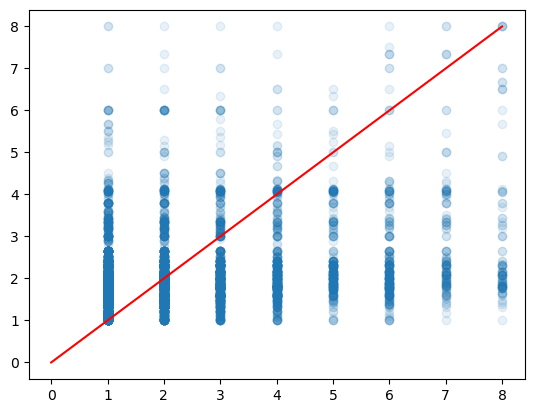

In [75]:
# Decision Tree
transformation_pipeline = Pipeline(stages=get_string_indexers(integrated_sales) + [
    VectorAssembler(inputCols=[
        'SalesPrice', 'Volume', 'DayOfMonth', 'PurchasePrice', 'ProfitRate',
        'Size_index', 'Classification_index', 'VendorNumber_index', 'DayOfWeek_index', 'Month_index'], 
                    outputCol='features')
])

dtr = DecisionTreeRegressor(maxDepth=10, labelCol='SalesQuantity', featuresCol='features', maxBins=256)

transformer = transformation_pipeline.fit(integrated_sales)
model = dtr.fit(transformer.transform(train))
result = model.transform(transformer.transform(test))

evaluate_regression_model(result, 'SalesQuantity')

dsp_df = result.toPandas()
plt.scatter(dsp_df['SalesQuantity'], dsp_df['prediction'], alpha=0.1)
plt.plot(range(0,9), c='r')
plt.show()

rmse: 1.3609629336960551
mse: 1.8522201068945732
mae: 0.9749608952709996
r2: 0.13237071168729608


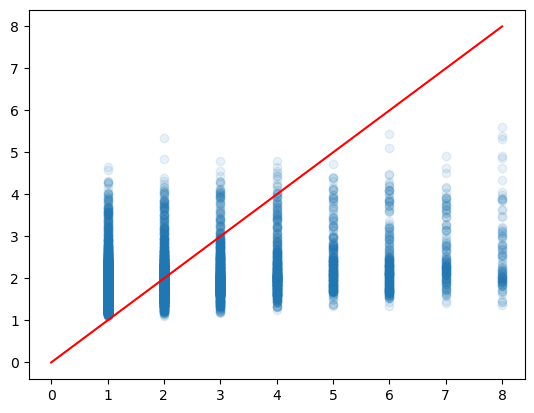

In [76]:
# Random Forest
transformation_pipeline = Pipeline(stages=get_string_indexers(integrated_sales) + [
    VectorAssembler(inputCols=[
        'SalesPrice', 'Volume', 'DayOfMonth', 'PurchasePrice', 'ProfitRate',
        'Size_index', 'Classification_index', 'VendorNumber_index', 'DayOfWeek_index', 'Month_index'], 
                    outputCol='features')
])

rfr = RandomForestRegressor(maxDepth=10, labelCol='SalesQuantity', featuresCol='features', maxBins=256)

transformer = transformation_pipeline.fit(integrated_sales)
model = rfr.fit(transformer.transform(train))
result = model.transform(transformer.transform(test))

evaluate_regression_model(result, 'SalesQuantity')

dsp_df = result.toPandas()
plt.scatter(dsp_df['SalesQuantity'], dsp_df['prediction'], alpha=0.1)
plt.plot(range(0,9), c='r')
plt.show()

## Build Final Models

In [77]:
import math

### Predicting Deliver Time

In [85]:
# Decision Tree
transformation_pipeline = Pipeline(stages=get_string_indexers(integrated_purchase_detail) + [
    VectorAssembler(inputCols=[
        'PurchasePrice', 'DayOfMonth', 'Price', 'Volume', 
        'Size_index', 'Classification_index', 'Month_index', 'VendorNumber_index'], 
                    outputCol='features')
])

transformer = transformation_pipeline.fit(integrated_purchase_detail)

test_data_size = 1 / (math.sqrt(8) + 1)
print(f'Test data size is {test_data_size}')
print('Baseline performance:')
train, test = integrated_purchase_detail.randomSplit([1-test_data_size, test_data_size], seed=13)
evaluate_regression_model(generate_baseline(test, 'DeliverTime'), 'DeliverTime', predictionCol='baseline_prediction', metrics=['mse', 'r2'])

cache = {}
def try_depth(max_depth):
    if cache.get(max_depth) is not None:
        return cache.get(max_depth)
    print('===============================================')
    print(f'Trying maxDepth: {max_depth}')
    dtr = DecisionTreeRegressor(maxDepth=max_depth, labelCol='DeliverTime', featuresCol='features', maxBins=256)
    model = dtr.fit(transformer.transform(train))
    result = model.transform(transformer.transform(test))
    cache[max_depth] = evaluate_regression_model(result, 'DeliverTime', metrics=['mse', 'r2'])
    return cache[max_depth]

def find_best_max_depth(left, right):
    if left == right:
        return left
    left_metric, right_metric = try_depth(left), try_depth(right)
    if left_metric['mse'] > right_metric['mse']:
        middle = math.ceil((left + right) / 2)
        return find_best_max_depth(middle, right)
    else:
        middle = math.floor((left + right) / 2)
        return find_best_max_depth(left, middle)

find_best_max_depth(3, 30)

Test data size is 0.2612038749637414
Baseline performance:
mse: 5.429466916299586
r2: 8.881784197001252e-15
Trying maxDepth: 26
mse: 0.7164003720715825
r2: 0.8680532761106069
Trying maxDepth: 30
mse: 0.7168284190250406
r2: 0.8679744383609609
Trying maxDepth: 28
mse: 0.7168284190250406
r2: 0.8679744383609609
Trying maxDepth: 27
mse: 0.7168284190250406
r2: 0.8679744383609609


26

In [86]:
dtr = DecisionTreeRegressor(maxDepth=26, labelCol='DeliverTime', featuresCol='features', maxBins=256)
model = dtr.fit(transformer.transform(train))
result = model.transform(transformer.transform(test))
evaluate_regression_model(result, 'DeliverTime', metrics=['mse', 'r2'])

mse: 0.7164003720715825
r2: 0.8680532761106069


{'mse': 0.7164003720715825, 'r2': 0.8680532761106069}

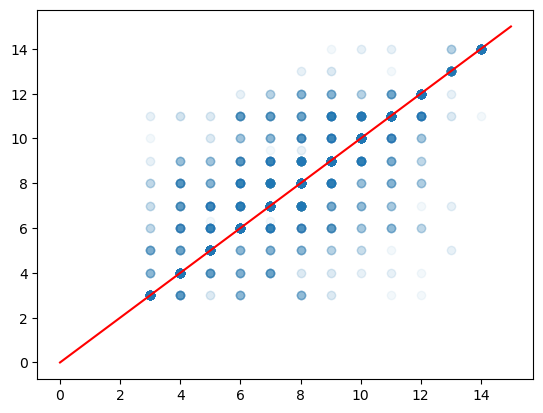

In [90]:
dsp_df = result.toPandas()
plt.scatter(dsp_df['DeliverTime'], dsp_df['prediction'], alpha=0.05)
plt.plot(range(0,16), c='r')
plt.show()

In [88]:
final_model_deliver_time = model

### Predicting Sales

In [102]:
# Random Forest
transformation_pipeline = Pipeline(stages=get_string_indexers(integrated_sales) + [
    VectorAssembler(inputCols=[
        'SalesPrice', 'Volume', 'DayOfMonth', 'PurchasePrice', 'ProfitRate',
        'Size_index', 'Classification_index', 'VendorNumber_index', 'DayOfWeek_index', 'Month_index'], 
                    outputCol='features')
])

transformer = transformation_pipeline.fit(integrated_sales)

test_data_size = 1 / (math.sqrt(10) + 1)
print(f'Test data size is {test_data_size}')
print('Baseline performance:')
train, test = integrated_sales.randomSplit([1-test_data_size, test_data_size], seed=13)
evaluate_regression_model(generate_baseline(test, 'SalesQuantity'), 'SalesQuantity', predictionCol='baseline_prediction', metrics=['mse', 'r2'])

cache = {}
def try_depth(max_depth):
    if cache.get(max_depth) is not None:
        return cache.get(max_depth)
    print('===============================================')
    print(f'Trying maxDepth: {max_depth}')
    rfr = RandomForestRegressor(maxDepth=max_depth, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
    model = rfr.fit(transformer.transform(train))
    result = model.transform(transformer.transform(test))
    cache[max_depth] = evaluate_regression_model(result, 'SalesQuantity', metrics=['mse', 'r2'])
    return cache[max_depth]

def find_best_max_depth(left, right):
    if left == right:
        return left
    left_metric, right_metric = try_depth(left), try_depth(right)
    if left_metric['mse'] > right_metric['mse']:
        middle = math.ceil((left + right) / 2)
        return find_best_max_depth(middle, right)
    else:
        middle = math.floor((left + right) / 2)
        return find_best_max_depth(left, middle)

find_best_max_depth(3, 30)

Test data size is 0.2402530733520421
Baseline performance:
mse: 2.134667874612771
r2: 1.2423395645555502e-13
Trying maxDepth: 3
mse: 1.9812831980184167
r2: 0.07185411764461214
Trying maxDepth: 30
mse: 1.9248741046649913
r2: 0.09827934942154659
Trying maxDepth: 17
mse: 1.8430826790749364
r2: 0.13659511112048617
Trying maxDepth: 23
mse: 1.9121688208939307
r2: 0.10423122789508366
Trying maxDepth: 20
mse: 1.882375466371576
r2: 0.11818813185971355
Trying maxDepth: 18
mse: 1.8575916439223217
r2: 0.1297982857126856


17

In [103]:
cache = {}
def try_num_trees(num_trees):
    if cache.get(num_trees) is not None:
        return cache.get(num_trees)
    print('===============================================')
    print(f'Trying number of trees: {num_trees}')
    rfr = RandomForestRegressor(maxDepth=6, numTrees=num_trees, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
    model = rfr.fit(transformer.transform(train))
    result = model.transform(transformer.transform(test))
    cache[max_depth] = evaluate_regression_model(result, 'SalesQuantity', metrics=['mse', 'r2'])
    return cache[max_depth]

def find_best_num_trees(left, right):
    if left == right:
        return left
    left_metric, right_metric = try_num_trees(left), try_num_trees(right)
    if left_metric['mse'] > right_metric['mse']:
        middle = math.ceil((left + right) / 2)
        return find_best_max_depth(middle, right)
    else:
        middle = math.floor((left + right) / 2)
        return find_best_max_depth(left, middle)

find_best_num_trees(2, 20)

Trying number of trees: 2
mse: 1.9594770425543386
r2: 0.08206936270610965
Trying number of trees: 20
mse: 1.9133754399068517
r2: 0.1036659788334986
Trying maxDepth: 11
mse: 1.8345123806451908
r2: 0.14060992697623098
Trying maxDepth: 20
mse: 1.882375466371576
r2: 0.11818813185971355
Trying maxDepth: 15
mse: 1.8263181896861558
r2: 0.1444485526736925
Trying maxDepth: 13
mse: 1.8190096397281974
r2: 0.14787229368974308
Trying maxDepth: 14
mse: 1.8172252972179312
r2: 0.14870818133834962


14

In [104]:
rfr = RandomForestRegressor(maxDepth=6, numTrees = 14, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
transformer = transformation_pipeline.fit(integrated_sales)
model = rfr.fit(transformer.transform(train))
result = model.transform(transformer.transform(test))
evaluate_regression_model(result, 'SalesQuantity', metrics=['mse', 'r2'])

mse: 1.9146741781177496
r2: 0.10305757589347053


{'mse': 1.9146741781177496, 'r2': 0.10305757589347053}

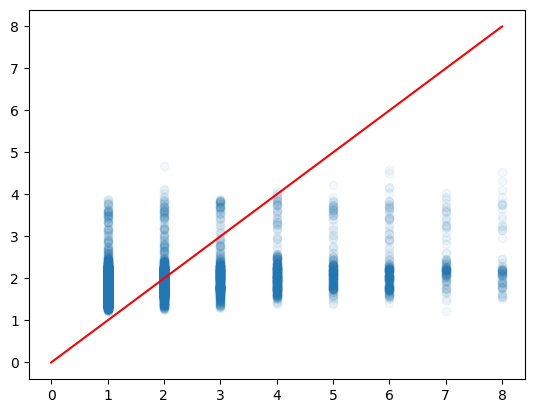

In [105]:
dsp_df = result.toPandas()
plt.scatter(dsp_df['SalesQuantity'], dsp_df['prediction'], alpha=0.05)
plt.plot(range(0,9), c='r')
plt.show()

In [106]:
final_model_sales = rfr